# Plot figure 2

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
# figure configuration
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")


## Data preparation

### Definitions

In [3]:
# dictionary definitions

data_dic = {0: "blds_continent_data_18-23_ai.json",
            1: "blds_africa_states_18-23_ai.json",
            2: "blds_northamerica_states_18-23_ai.json",
            3: "blds_europe_states_18-23_ai.json",
            4: "blds_asia_states_18-23_ai.json",}
geojson_folder_dic = {0: "geojson-continent-states",
                      1: "geojson-africa-states",
                      2: "geojson-northamerica-states",
                      3: "geojson-europe-states",
                      4: "geojson-asia-states",}

In [4]:
# user input definition

while True:
    try:
        user_d_spec = int(input("Which data do you want to plot?\
                            Enter 0 for stats by continents (2018–2023),\
                            1 for stats by Africa states (2018–2023),\
                            2 for stats by North-Central America states (2018–2023),\
                            3 for stats by Europe states (2018–2023),\
                            4 for stats by Asia states (2018–2023):"
                                ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_d_spec not in range(len(data_dic)):
        print("Please enter 0, 1, 2, 3 or 4.")
        continue
    break


In [5]:
# function definitions

def data_spec(data_dic):
    
    with open(f"downloaded-data\\{data_dic[user_d_spec]}", "r") as f:
        data = json.load(f)
    return data


def get_geojson_names(home_dir, geojson_folder_dic):
    geojson_dir = os.path.join(home_dir, geojson_folder_dic[user_d_spec], "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [6]:
os.chdir('..')

data = data_spec(data_dic)

home_dir = os.getcwd()


### Edit the obtained data into desired shape to create a DataFrame

In [7]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [8]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [9]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [10]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic)


['0_Costa Rica.geojson', '10_Mexico.geojson', '11_Belize.geojson', '12_Panama.geojson', '13_Bahamas.geojson', '14_Trinidad and Tobago.geojson', '15_Grenada.geojson', '16_St. Vin. and Gren..geojson', '17_Barbados.geojson', '18_Saint Lucia.geojson', '19_Dominica.geojson', '1_Nicaragua.geojson', '20_Antigua and Barb..geojson', '21_St. Kitts and Nevis.geojson', '22_Jamaica.geojson', '23_Bajo Nuevo Bank.geojson', '24_Serranilla Bank.geojson', '2_Haiti.geojson', '3_Dominican Rep..geojson', '4_El Salvador.geojson', '5_Guatemala.geojson', '6_Cuba.geojson', '7_Honduras.geojson', '8_United States of America.geojson', '9_Canada.geojson']


In [11]:
geojson_names_2 = geojson_names

id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1]
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [12]:
# merge df with region names based on ids
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
df.head()

,feature,source,timestamp,value,year,id,name
0,0,remainder,2018-01-01T00:00:00Z,61906.0,2018,0,Costa Rica
1,0,remainder,2019-01-01T00:00:00Z,76289.0,2019,0,Costa Rica
2,0,remainder,2020-01-01T00:00:00Z,86564.0,2020,0,Costa Rica
3,0,remainder,2021-01-01T00:00:00Z,106221.0,2021,0,Costa Rica
4,0,remainder,2022-01-01T00:00:00Z,134409.0,2022,0,Costa Rica


### Filtering the data

In [13]:
df = df.groupby("name").filter(
    lambda x: x["value"].sum() != 0)


In [14]:
# get the number of AI Microsoft (source=microsoft/BuildingFootprints) / manually mapped (remainder) buildings for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped


In [15]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"num_of_blds", "value_y":"total_blds"})
merged_data["percentage"] = (merged_data["num_of_blds"] / merged_data["total_blds"]) * 100
# merged_data.head(10)


In [16]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source                               year
remainder                            2018    100.0
                                     2019    100.0
                                     2020    100.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
source=microsoft/BuildingFootprints  2018      0.0
                                     2019      0.0
                                     2020    100.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
Name: percentage, dtype: float64

In [17]:
merged_data

,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
0,0,remainder,2018-01-01T00:00:00Z,61906.0,2018,0,Costa Rica,28496571.0,0.217240
1,0,remainder,2019-01-01T00:00:00Z,76289.0,2019,0,Costa Rica,33936935.0,0.224796
2,0,remainder,2020-01-01T00:00:00Z,86564.0,2020,0,Costa Rica,41374001.0,0.209223
3,0,remainder,2021-01-01T00:00:00Z,106221.0,2021,0,Costa Rica,49255789.0,0.215652
4,0,remainder,2022-01-01T00:00:00Z,134409.0,2022,0,Costa Rica,56548562.0,0.237688
...,...,...,...,...,...,...,...,...,...
271,9,source=microsoft/BuildingFootprints,2019-01-01T00:00:00Z,0.0,2019,9,Canada,0.0,NaN
272,9,source=microsoft/BuildingFootprints,2020-01-01T00:00:00Z,0.0,2020,9,Canada,13935.0,0.000000
273,9,source=microsoft/BuildingFootprints,2021-01-01T00:00:00Z,39290.0,2021,9,Canada,2310941.0,1.700173
274,9,source=microsoft/BuildingFootprints,2022-01-01T00:00:00Z,110173.0,2022,9,Canada,5369336.0,2.051892


In [18]:
# create the dataframe by the source
# remainder = manually mapped buildings
df_rem = merged_data.loc[(merged_data["source"] == "remainder"), :]
# buiildings used from Microsoft AI
df_ai = merged_data.loc[(merged_data["source"] == "source=microsoft/BuildingFootprints"), :]
# df_ai.head()


In [19]:
# exclude states which give zero in total
# df_rem = df_rem.groupby("name").filter(
#     lambda x: x["num_of_blds"].sum() != 0)
# df_ai = df_ai.groupby("name").filter(
#     lambda x: x["num_of_blds"].sum() != 0)


In [20]:
# verify the sum
# df_rem.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [21]:
# verify the sum
# df_ai.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [22]:
# how the DataFrame looks like – manually mapped buildings
df_rem.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
0,0,remainder,2018-01-01T00:00:00Z,61906.0,2018,0,Costa Rica,28496571.0,0.217240
1,0,remainder,2019-01-01T00:00:00Z,76289.0,2019,0,Costa Rica,33936935.0,0.224796
2,0,remainder,2020-01-01T00:00:00Z,86564.0,2020,0,Costa Rica,41374001.0,0.209223
3,0,remainder,2021-01-01T00:00:00Z,106221.0,2021,0,Costa Rica,49255789.0,0.215652
4,0,remainder,2022-01-01T00:00:00Z,134409.0,2022,0,Costa Rica,56548562.0,0.237688


In [23]:
# how the DataFrames look like – AI Microsoft buildings
df_ai.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
6,0,source=microsoft/BuildingFootprints,2018-01-01T00:00:00Z,0.0,2018,0,Costa Rica,0.0,NaN
7,0,source=microsoft/BuildingFootprints,2019-01-01T00:00:00Z,0.0,2019,0,Costa Rica,0.0,NaN
8,0,source=microsoft/BuildingFootprints,2020-01-01T00:00:00Z,0.0,2020,0,Costa Rica,13935.0,0.0
9,0,source=microsoft/BuildingFootprints,2021-01-01T00:00:00Z,0.0,2021,0,Costa Rica,2310941.0,0.0
10,0,source=microsoft/BuildingFootprints,2022-01-01T00:00:00Z,0.0,2022,0,Costa Rica,5369336.0,0.0


## Plots

### Manually mapped buildings

In [24]:
df_rem.groupby("year")["num_of_blds"].sum().loc[2023] == df_rem.loc[df_rem["year"] == 2023, "total_blds"]

5      True
17     True
29     True
41     True
53     True
65     True
77     True
89     True
101    True
113    True
125    True
137    True
149    True
161    True
173    True
185    True
197    True
209    True
221    True
233    True
245    True
257    True
269    True
Name: total_blds, dtype: bool

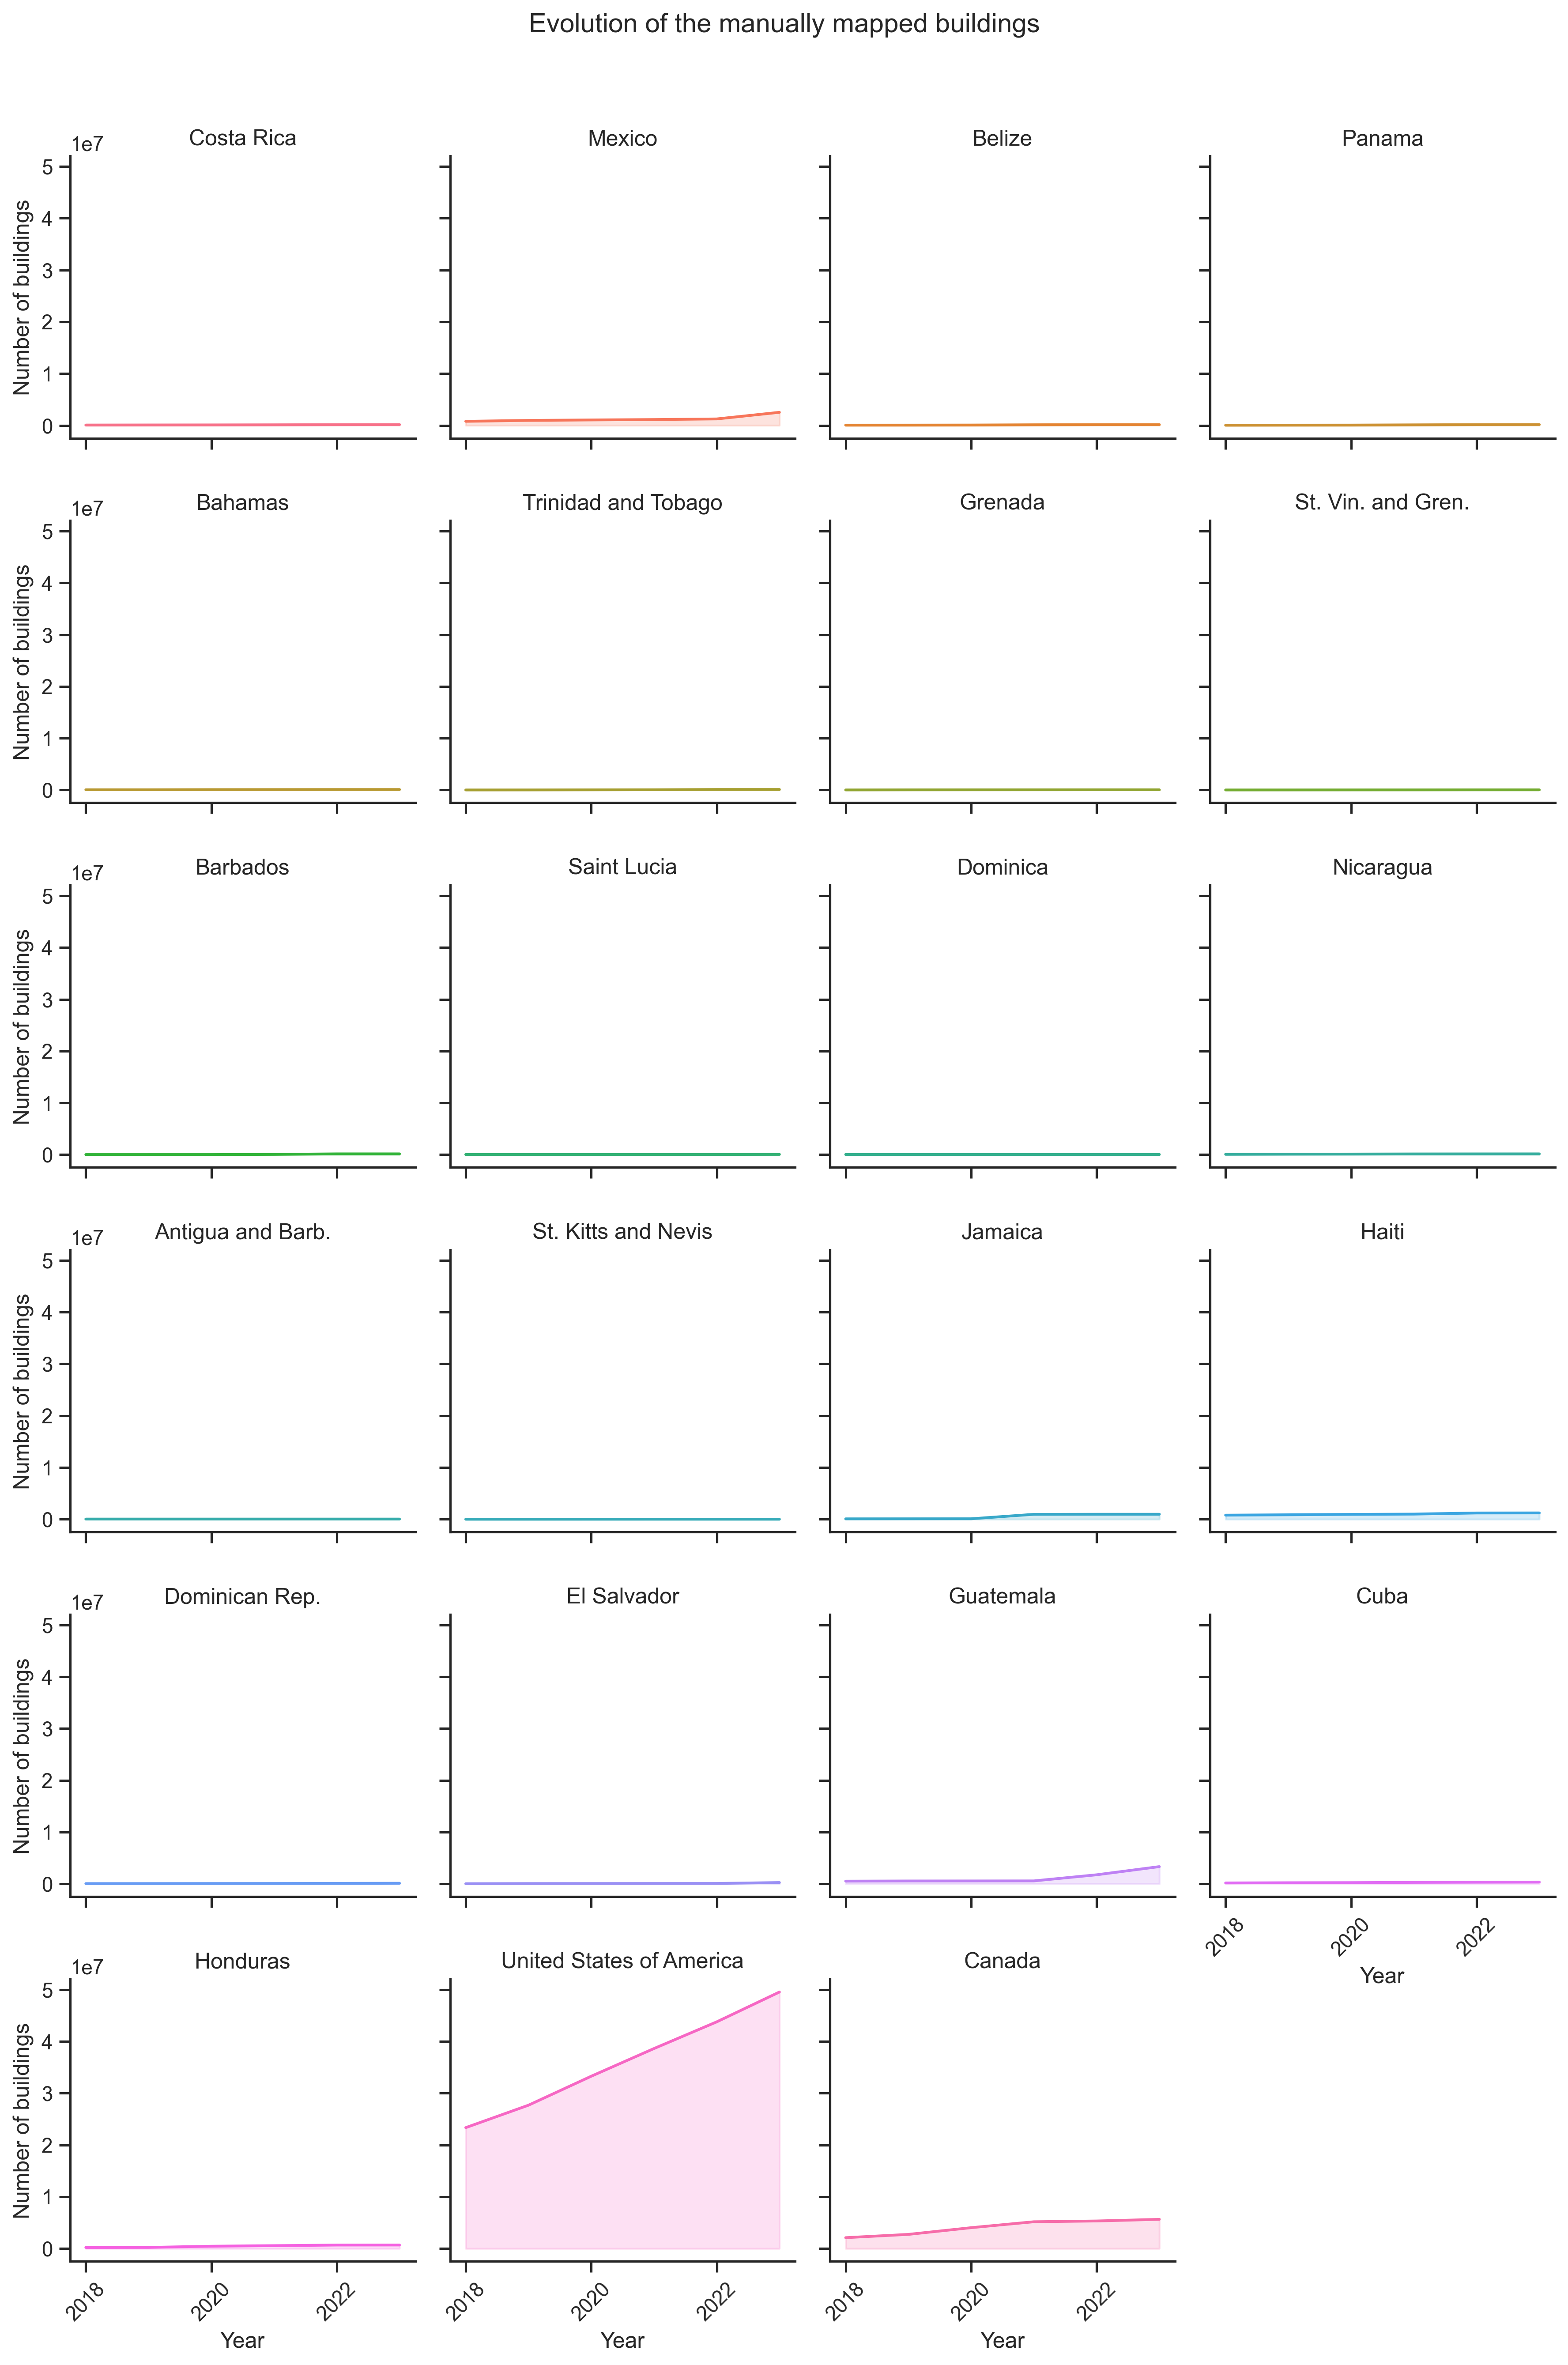

In [25]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)

# plot the sum line over the plot
# g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# # add the line over the area with the plot function
# g = g.map(plt.plot, 'year', 'total_blds')

# # fill the area with fill_between
# g = g.map(plt.fill_between, 'year', 'total_blds',
#           alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# show the graph
plt.show()


#### Try to add summary plot

In [26]:
df_rem_tot = df_rem.groupby("year")["total_blds"].last().reset_index()
df_rem_tot

,year,total_blds
0,2018,28496571.0
1,2019,33936935.0
2,2020,41374001.0
3,2021,49255789.0
4,2022,56548562.0
5,2023,65794687.0


C:\Users\milan\AppData\Local\Temp\ipykernel_28900\1247388640.py:42: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


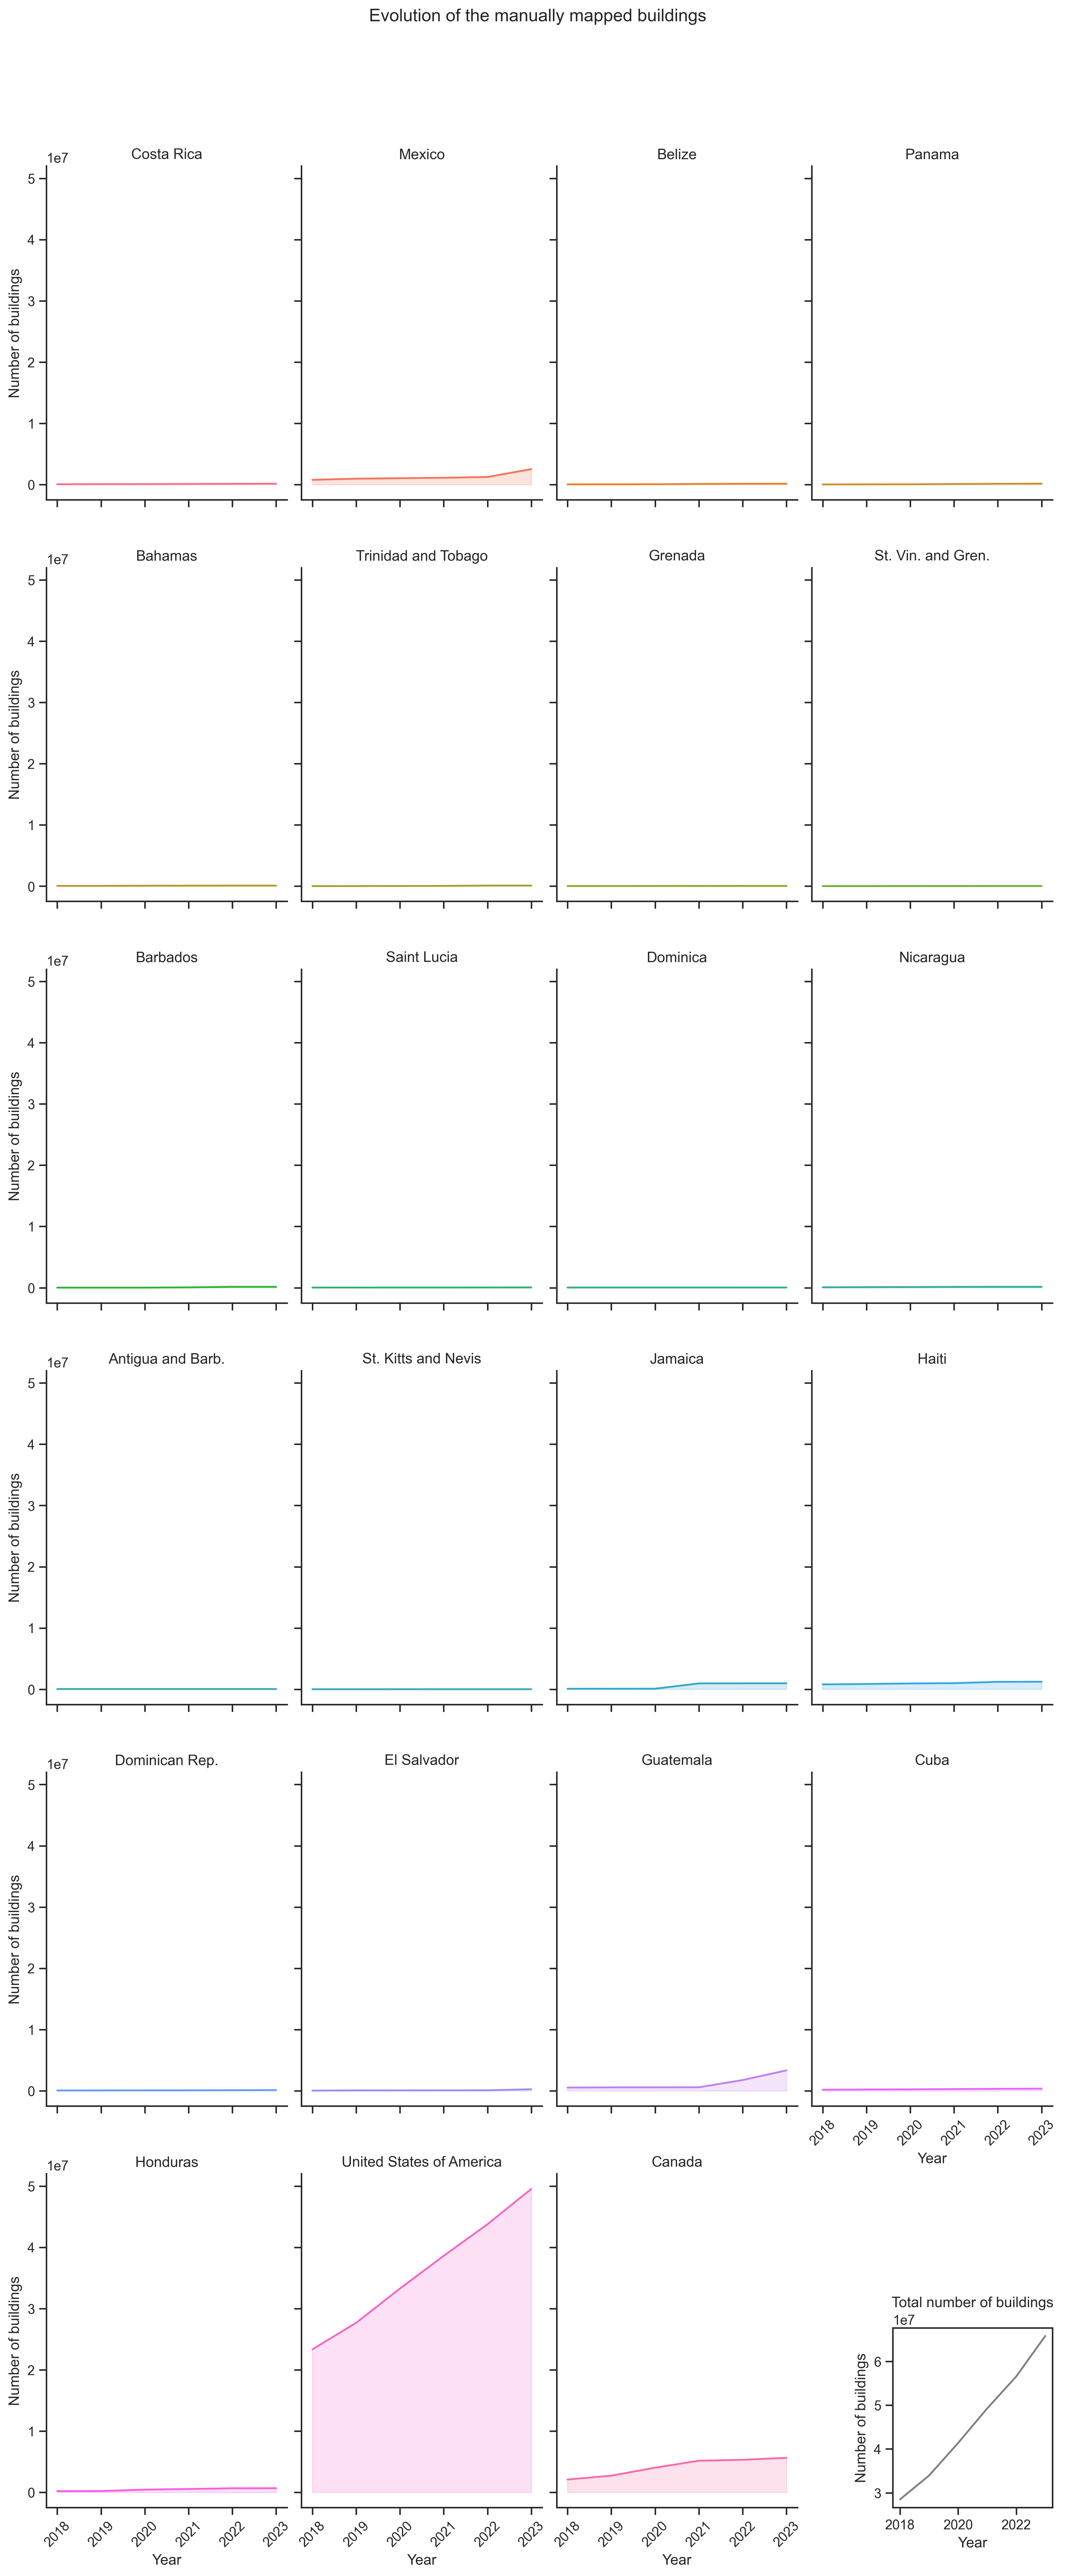

In [32]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_rem, col='name', hue='name',
                  col_wrap=4, height=4, aspect=1.2)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'num_of_blds')
g = g.map(plt.fill_between, 'year', 'num_of_blds', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped buildings')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(11, 6, 66)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_rem_tot, x='year',
             y='total_blds', color='black', alpha=0.5)

# set the title and axes labels for the new plot axis
ax2.set_title('Total number of buildings')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of buildings')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(12, 30)

# show the plot
plt.show()


### Microsoft AI buildings

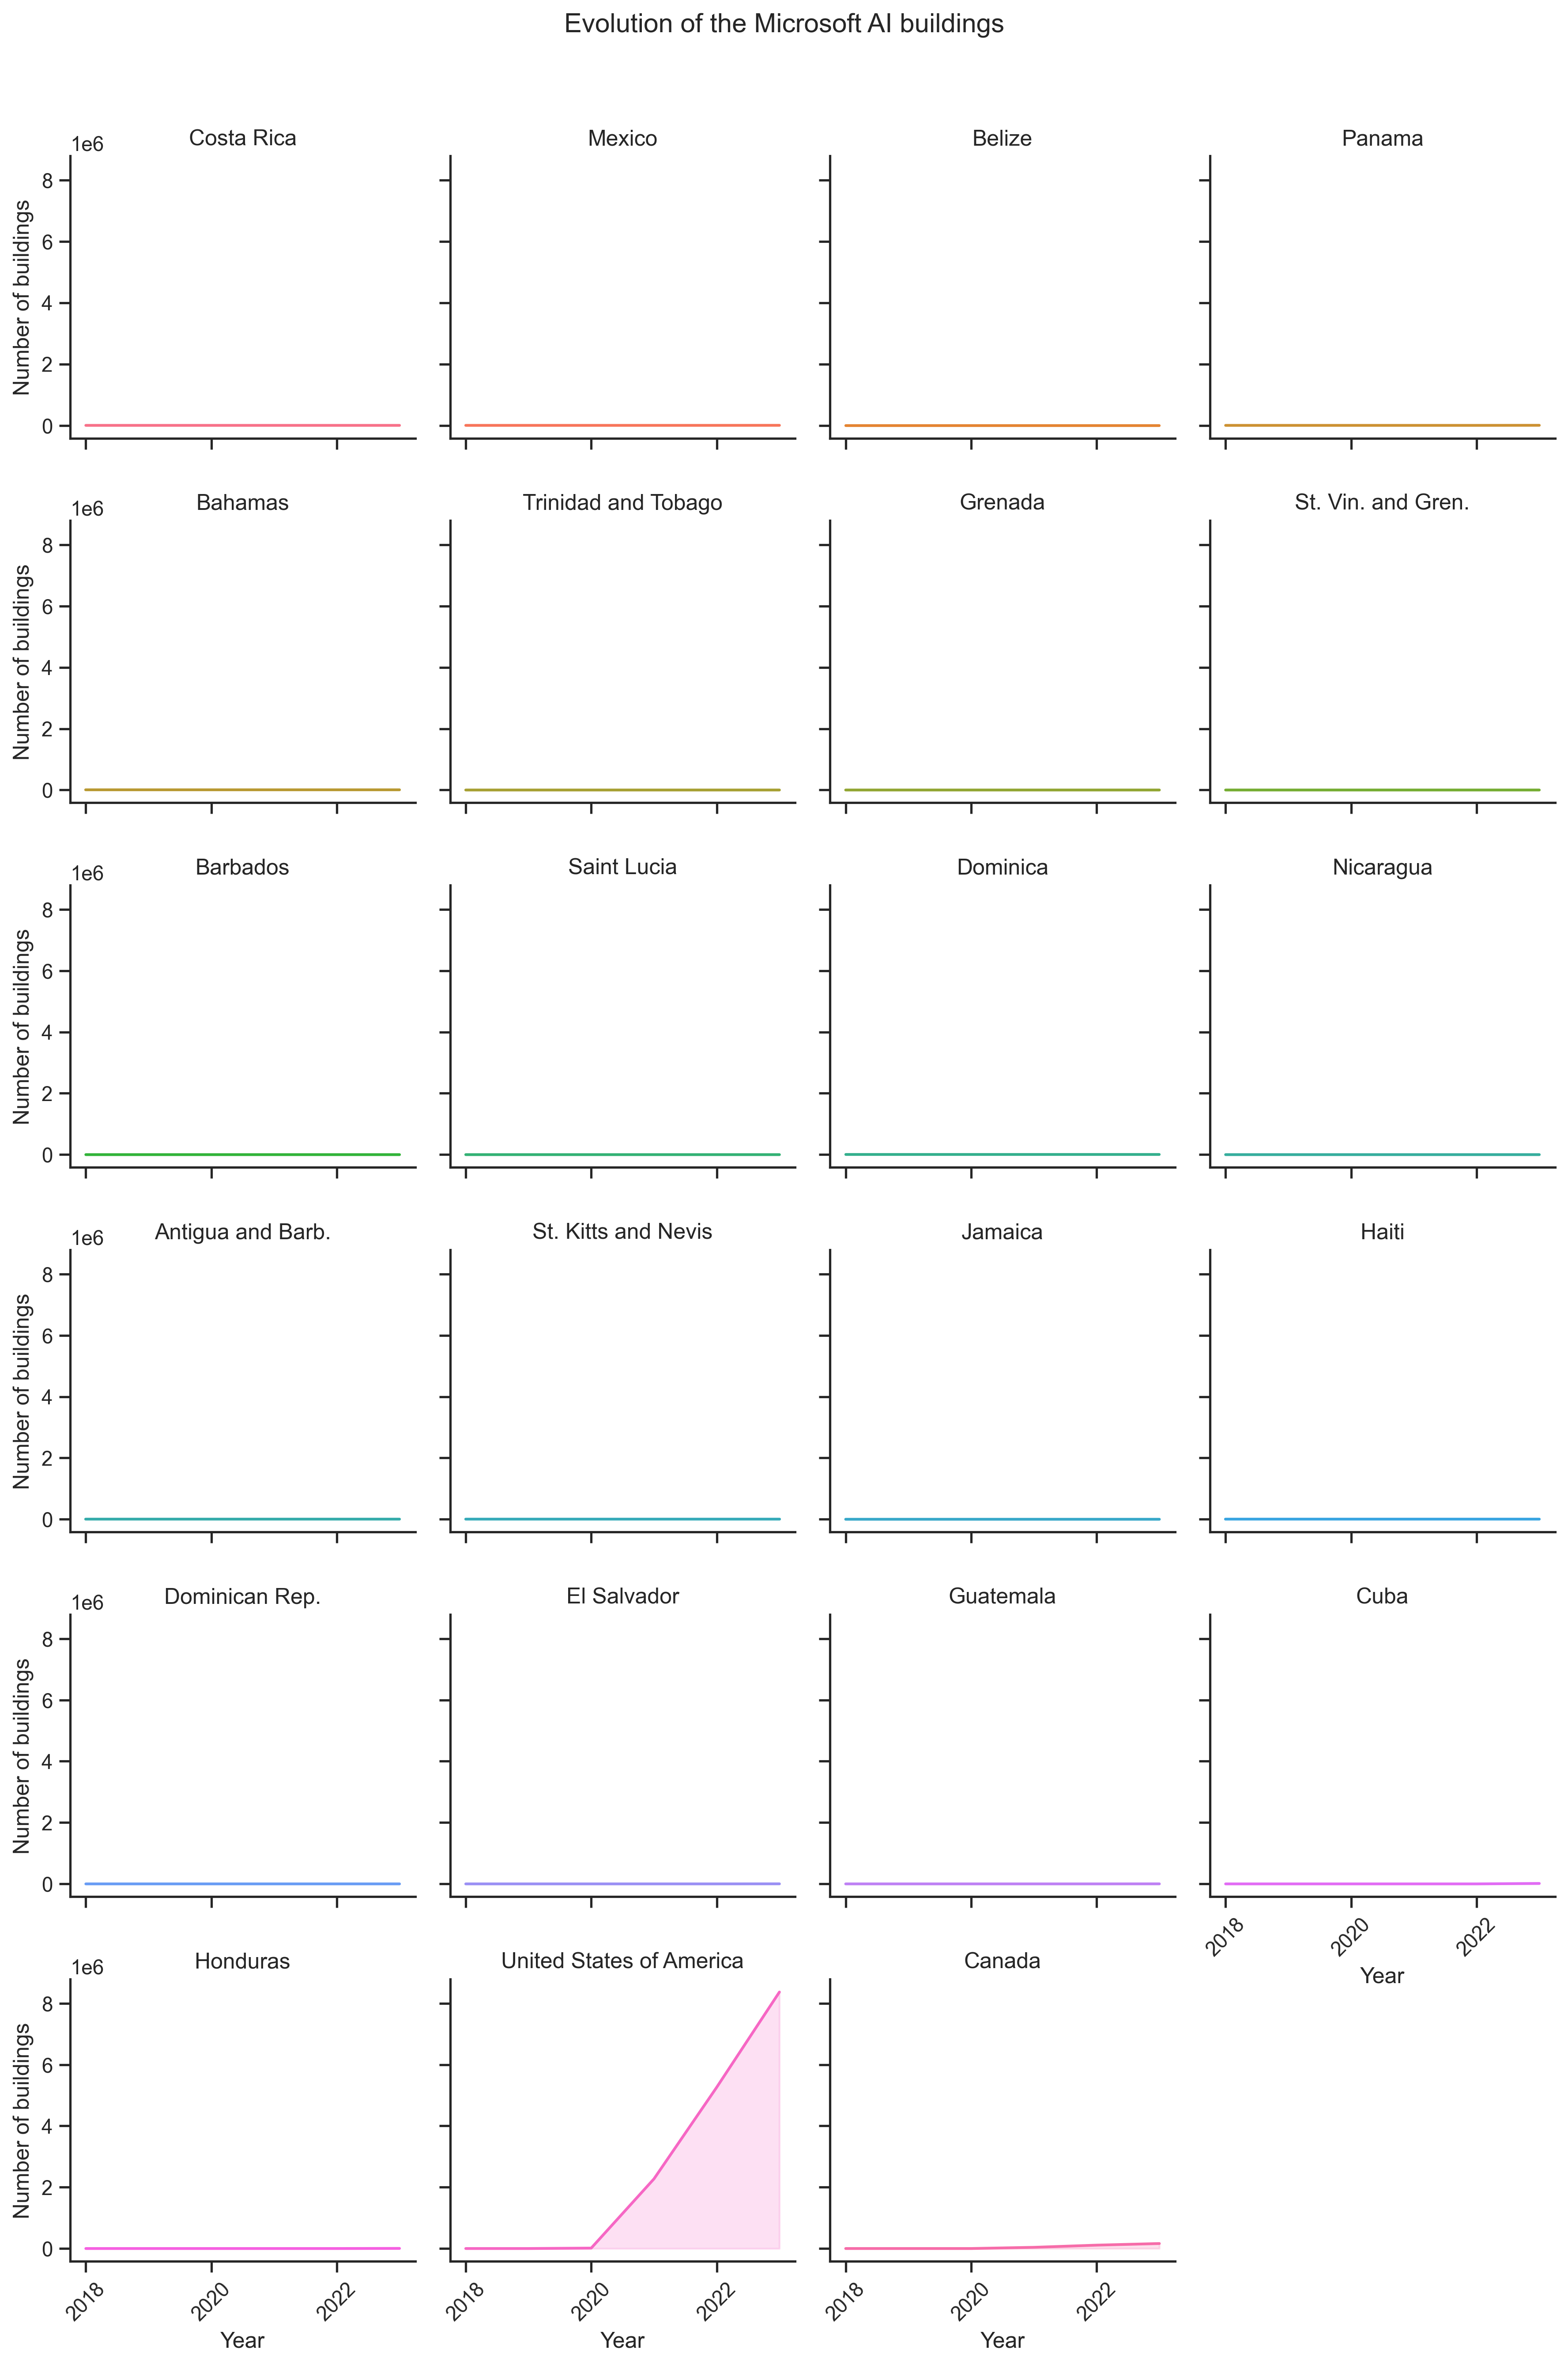

In [28]:
# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)

# plot the sum line over the plot
# g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# Calculate and add total values to each subplot

# for ax in g.axes.flat:
#     # Calculate total values for each day and sex
#     totals = df_ai.groupby(['year'])[['num_of_blds']].sum()
#     # Get the day and sex for the current subplot
#     day, sex = ax.get_title().split(' = ')
#     # Add the total values to the current subplot
#     ax.text(0.05, 0.95, f"Total: ${totals.loc[day, sex]['total_bill']:.2f}, Tip: ${totals.loc[day, sex]['tip']:.2f}",
#             transform=ax.transAxes, fontsize=10, verticalalignment='top')



# show the graph
plt.show()


#### Try to add summary plot

In [29]:
df_ai_tot = df_ai.groupby("year")["total_blds"].last().reset_index()
df_ai_tot

,year,total_blds
0,2018,0.0
1,2019,0.0
2,2020,13935.0
3,2021,2310941.0
4,2022,5369336.0
5,2023,8556752.0


C:\Users\milan\AppData\Local\Temp\ipykernel_28900\1766372436.py:42: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


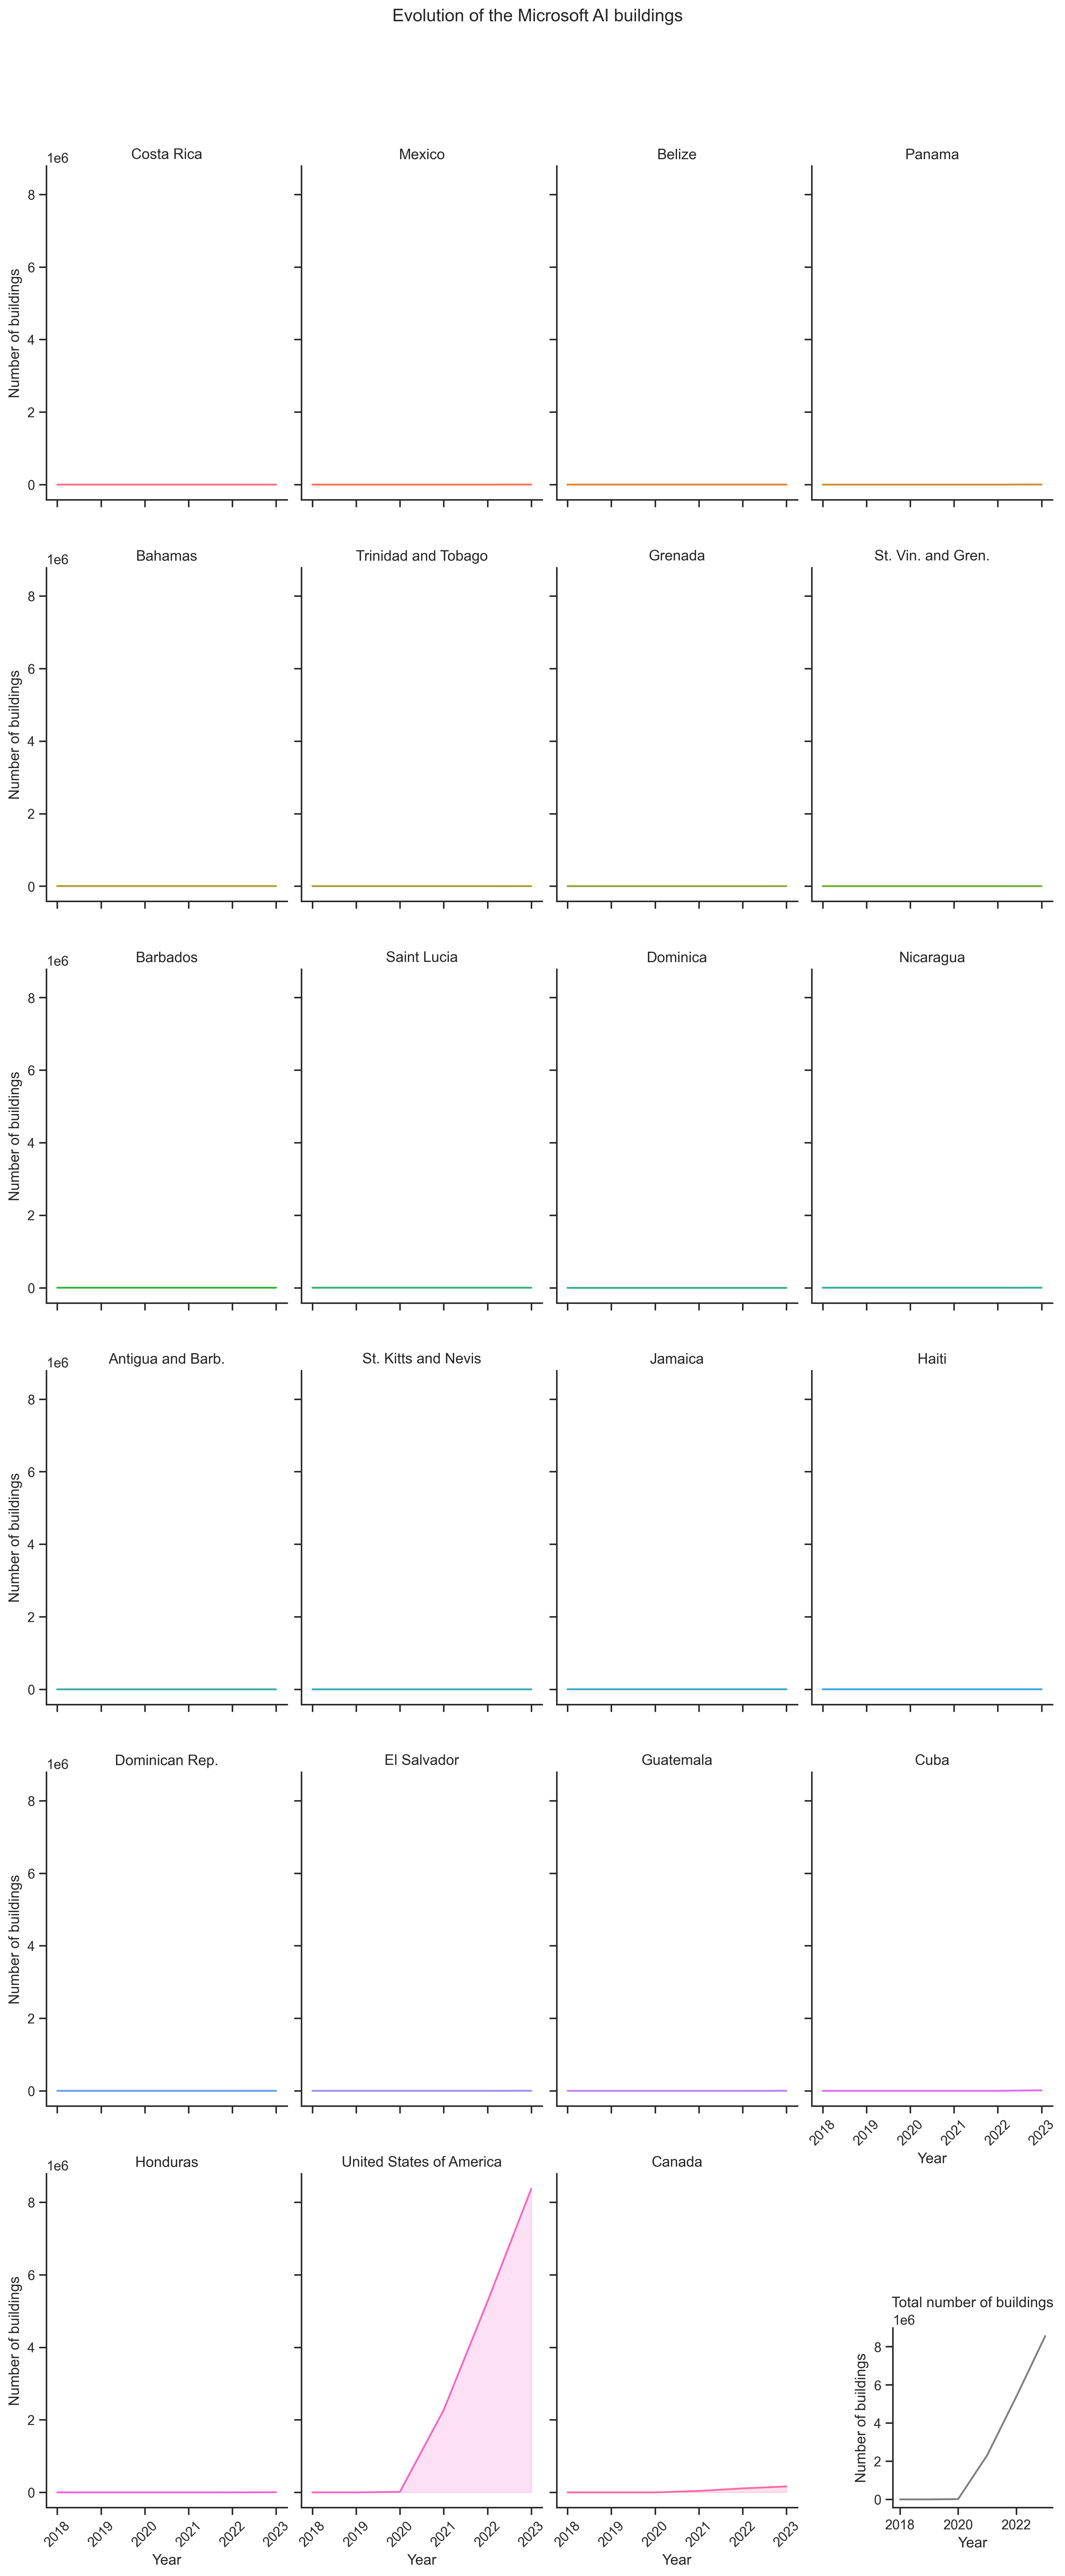

In [30]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_ai, col='name', hue='name',
                  col_wrap=4, height=4, aspect=1.2)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'num_of_blds')
g = g.map(plt.fill_between, 'year', 'num_of_blds', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(11, 6, 66)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_ai_tot, x='year',
             y='total_blds', color='black', alpha=0.5)

# set the title and axes labels for the new plot axis
ax2.set_title('Total number of buildings')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of buildings')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(12, 30)

# show the plot
plt.show()


### AI Microsoft and Manually mapped buildings together

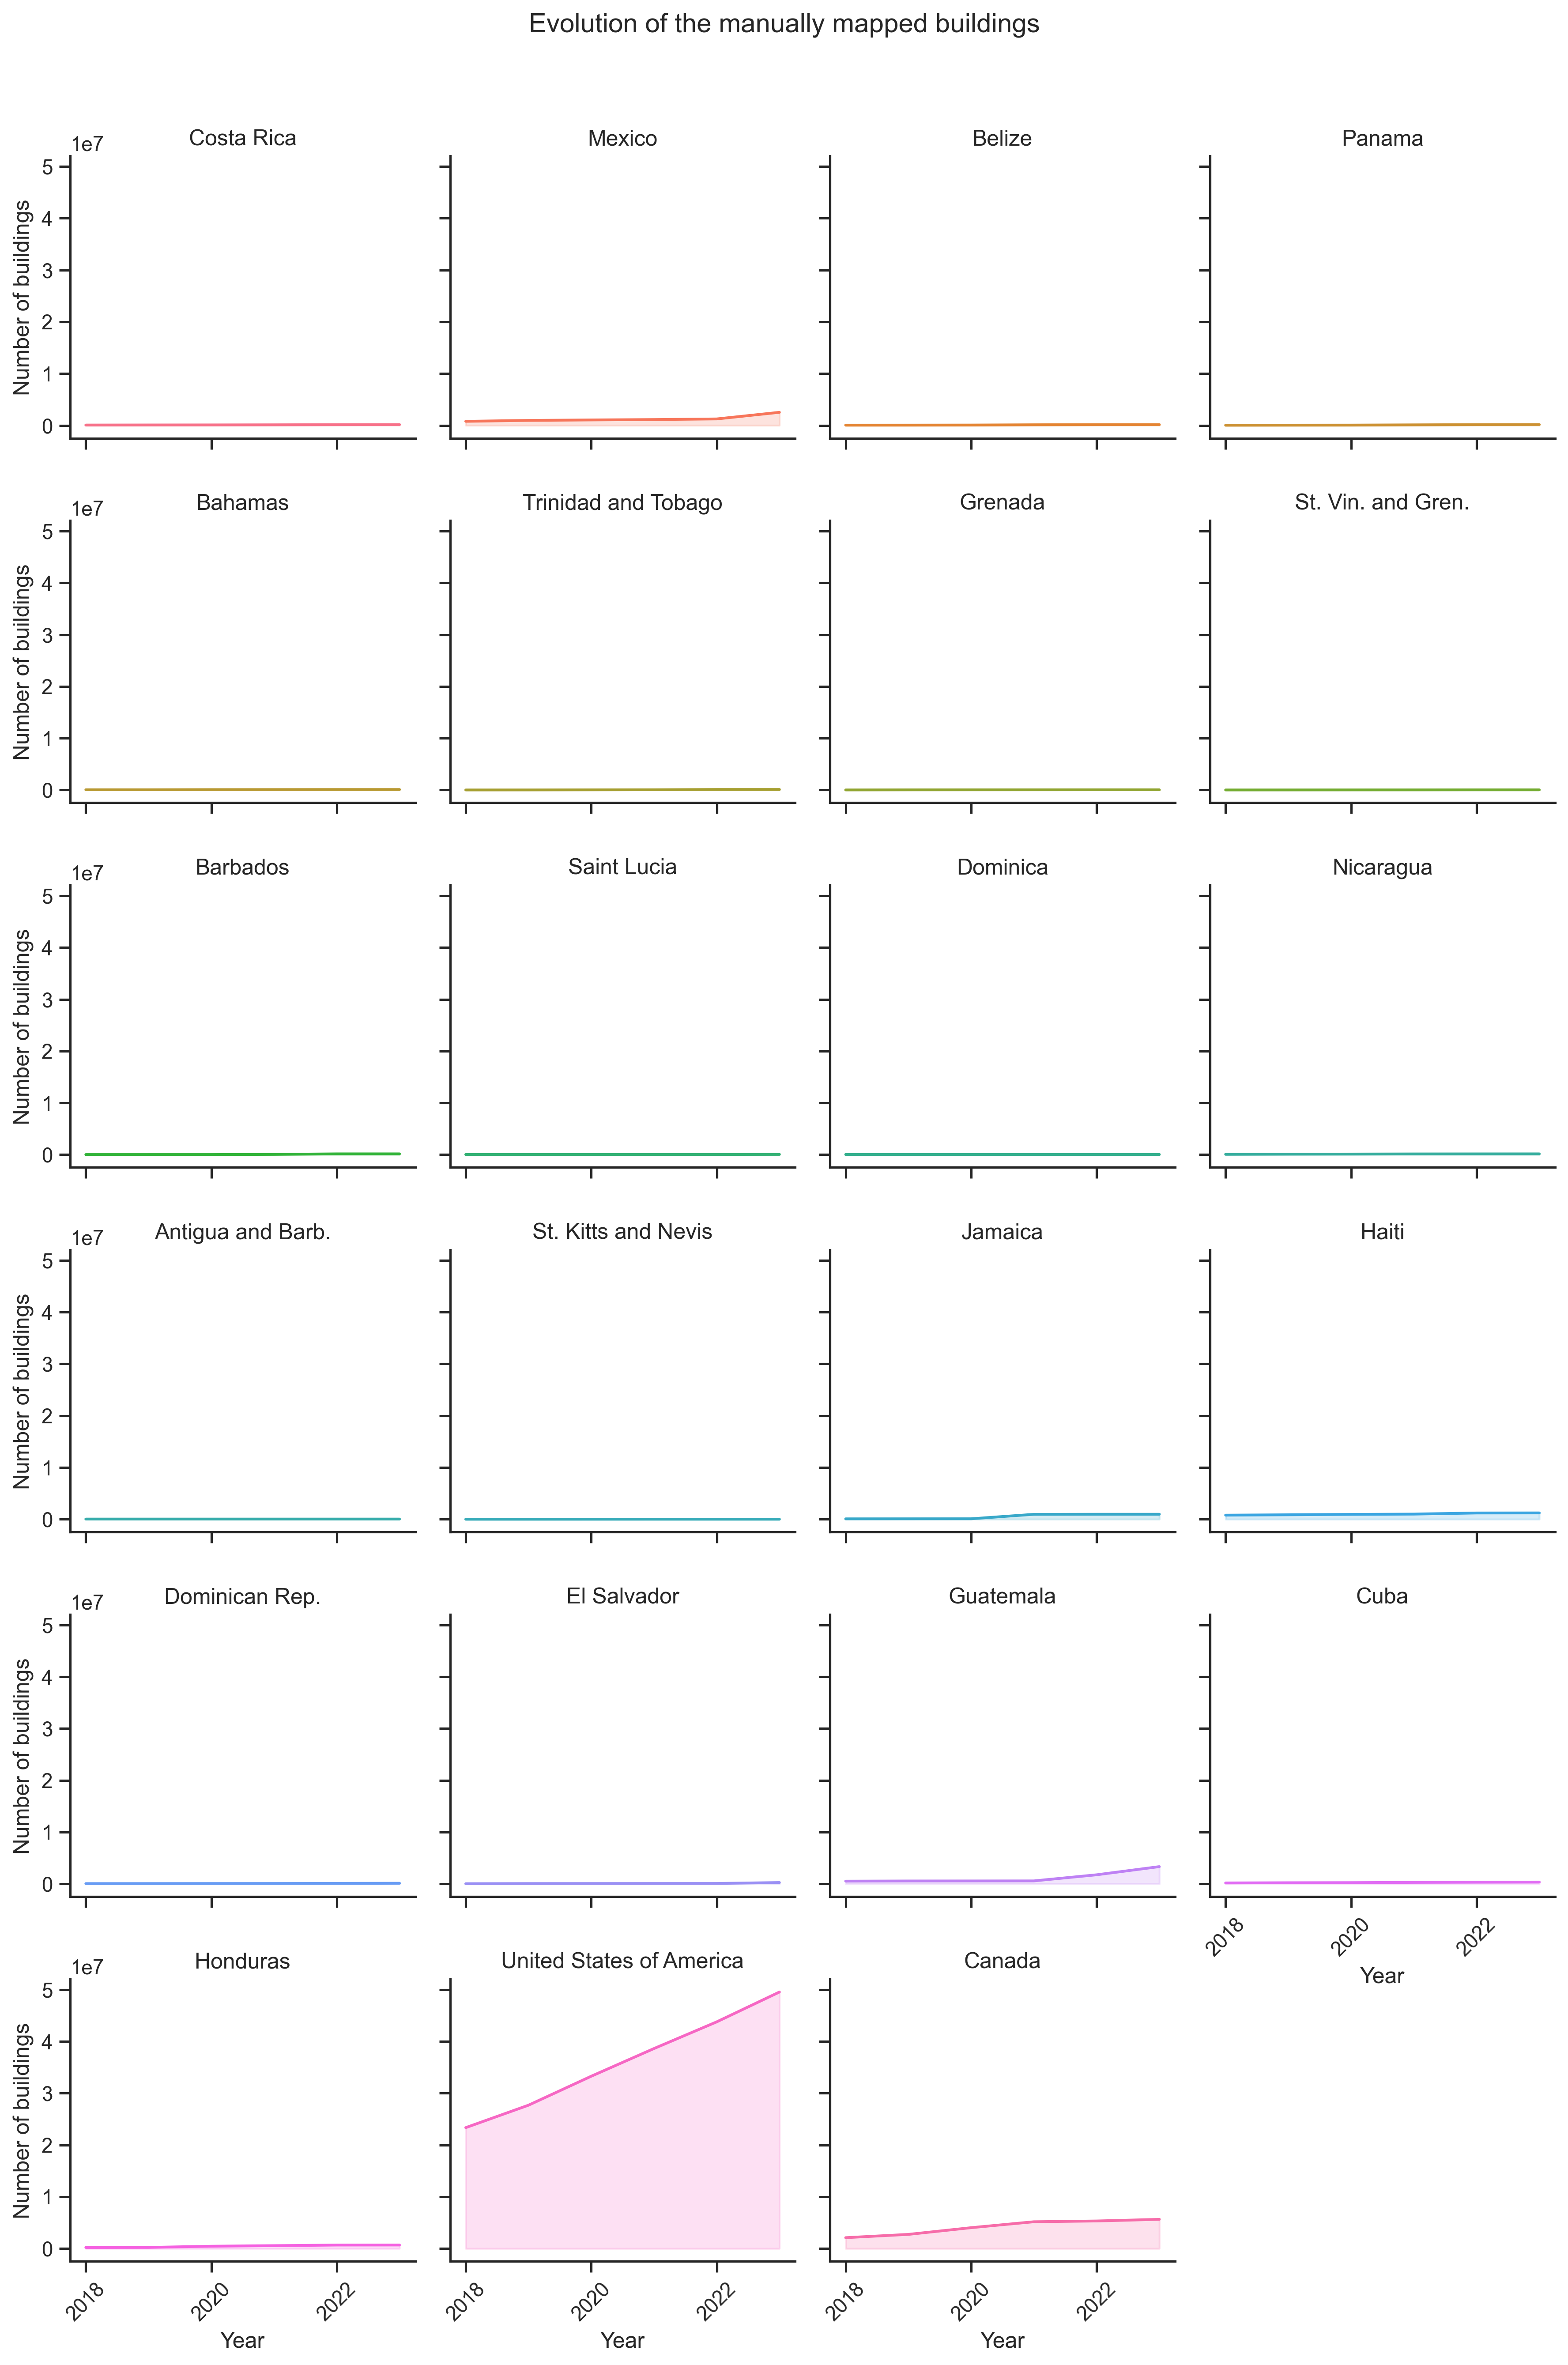

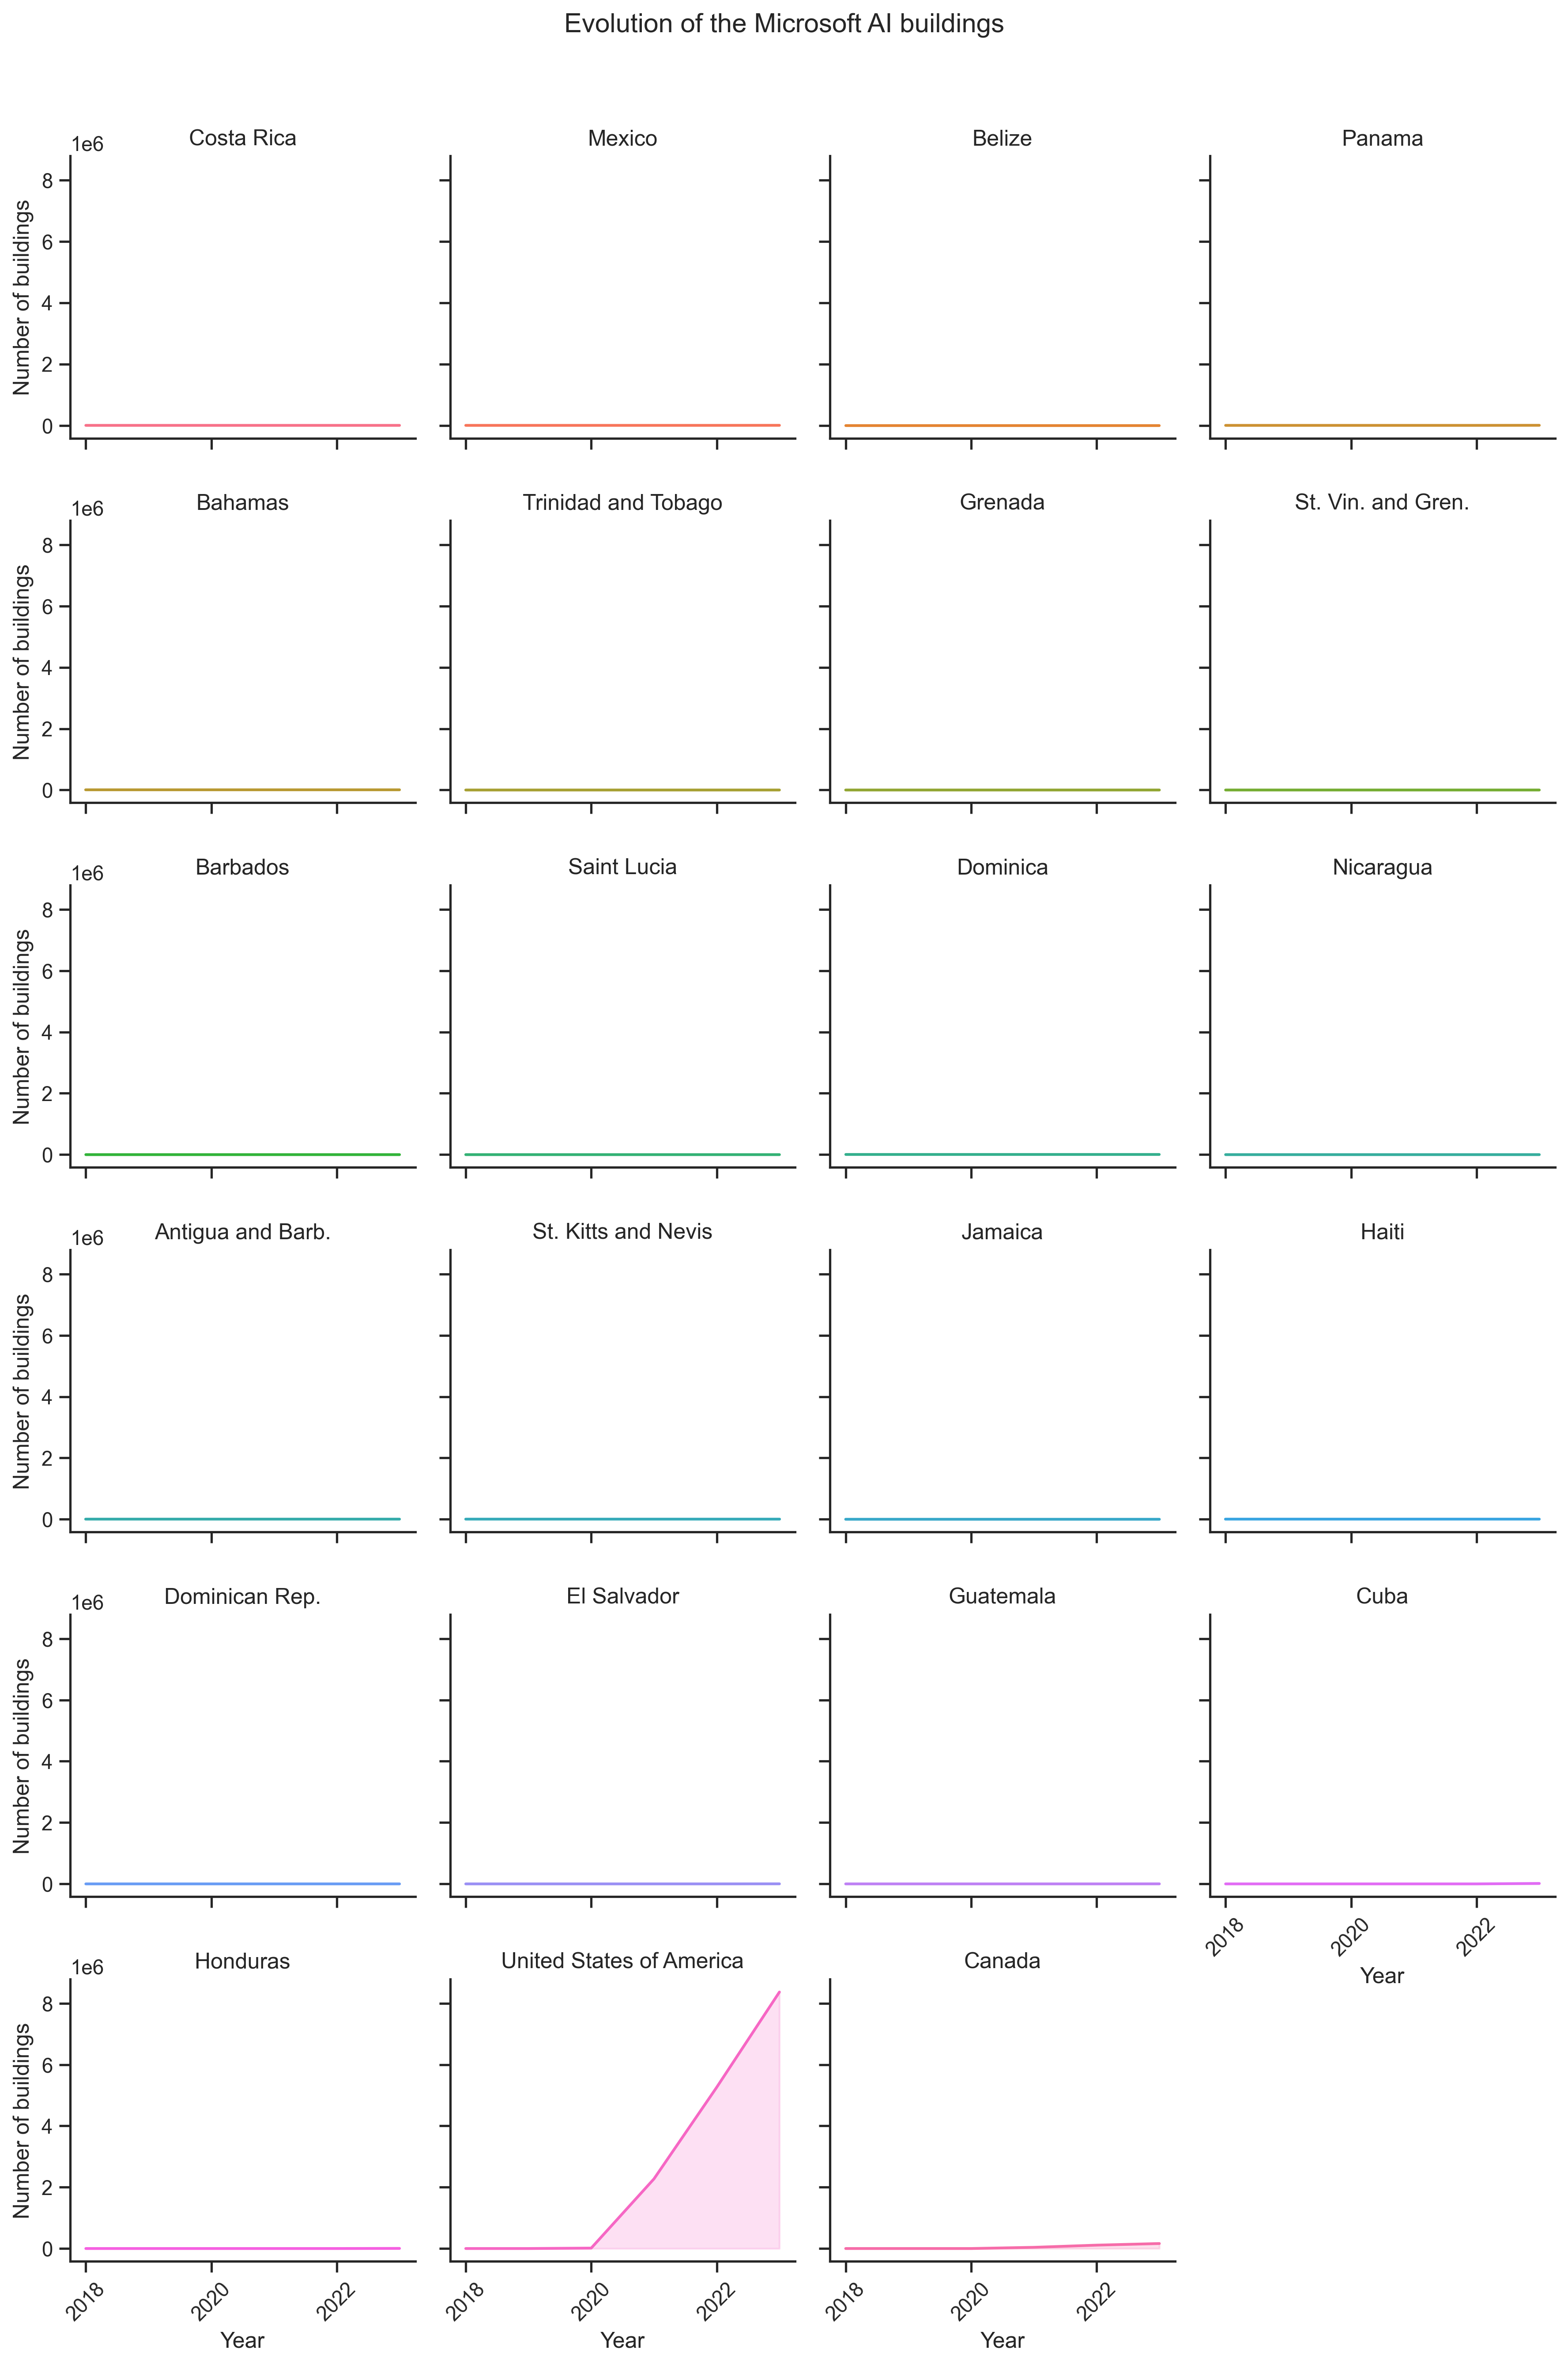

In [31]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)#.set_titles("{col_name}")

# plot the sum line over the plot
# g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# g.set(ylim=(0, 100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# Show the graph
plt.show()


# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)  # .set_titles("{col_name}")

# plot the sum line over the plot
# g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# g.set(ylim=(0,100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")

# show the graph
plt.show()
